In [27]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys

import csv
import datetime
import itertools
import numpy as np
import pandas as pd
import random
import re
from collections import defaultdict

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context(rc={
       "figure.figsize": (16, 10),
       "axes.titlesize": 14})

import sklearn

from IPython.display import Image, display
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

from os.path import expanduser
sys.path.insert(1, '{}/datsci'.format(expanduser('~')))
from datsci import eda
from datsci import kaggle as kg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

In [2]:
kfood_data_file = 'data/kfood.txt'
kfood_data_file_raw = 'data/kfood.raw.txt'

catpat = re.compile(r'/(\w+)\.\d+\.jpg$')

def encode_category(df):
    # Encode categories as numerical index
    categories = sorted(set(df.category))
    cat2idx = {c: i for i, c in enumerate(categories)}
    df['category'] = df.category.apply(lambda c: cat2idx[c])
    return categories

def load_data():
    if os.path.exists(kfood_data_file):
	df = pd.read_csv(kfood_data_file)
	return df, df.columns[1:-1], encode_category(df)
    
    if not os.path.exists(kfood_data_file_raw):
	raise ValueError("data files don't exist")
    
    df = pd.read_csv(kfood_data_file_raw, header=None)
    feature_cols = list(df.columns[1:])
    for i in xrange(len(feature_cols)):
	feature_cols[i] = "feature{}".format(i)
    df.columns = ['filepath'] + feature_cols
    df['category'] = df.filepath.apply(lambda _fp: catpat.search(_fp).group(1))
    
    df.to_csv(kfood_data_file, index=False)
    return df, feature_cols, encode_category(df)

In [3]:
df, feature_cols, y_cats = load_data()

In [8]:
df.category.apply(cat_name).value_counts().mean()

173.5

In [4]:
cat_name = lambda c: y_cats[c]
df.category.apply(cat_name).value_counts()

galbijjim        219
kimbab           217
bibimbab         214
hotteok          210
nangmyun         207
dakgalbi         205
sullungtang      193
japchae          193
bulgogi          183
samgyupsal       173
bossam           173
dakbokeumtang    171
jeyookbokkeum    165
samgyetang       158
ddukbokee        150
lagalbi          148
jeon             134
kimchi           127
ramen            118
yookgyejang      112
Name: category, dtype: int64

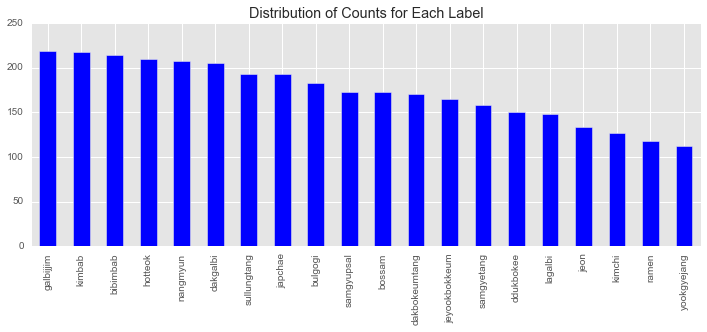

In [7]:
df.category.apply(cat_name).value_counts().plot(kind='bar', title="Distribution of Counts for Each Label", figsize=(12,4))

| Name           |  Number of samples
| ---		 | ---
| galbijjim      |  219
| kimbab         |  217
| bibimbab       |  214
| hotteok        |  210
| nangmyun       |  207
| dakgalbi       |  205
| sullungtang    |  193
| japchae        |  193
| bulgogi        |  183
| samgyupsal     |  173
| bossam         |  173
| dakbokeumtang  |  171
| jeyookbokkeum  |  165
| samgyetang     |  158
| ddukbokee      |  150
| lagalbi        |  148
| jeon           |  134
| kimchi         |  127
| ramen          |  118
| yookgyejang    |  112

In [43]:
df.shape

(3470, 2050)

In [10]:
df.describe()[['feature0', 'feature1', 'feature2', 'feature3', 'feature4',]]

,feature0,feature1,feature2,feature3,feature4
count,3470.000000,3470.000000,3470.000000,3470.000000,3470.000000
mean,0.292122,0.409072,0.527338,0.205257,0.341956
std,0.210247,0.310620,0.348090,0.196429,0.309863
min,0.002776,0.000000,0.009342,0.000000,0.000000
25%,0.135991,0.177316,0.271595,0.066020,0.121058
50%,0.244641,0.341317,0.450077,0.147333,0.259115
75%,0.396790,0.555601,0.708050,0.281080,0.469292
max,1.751740,2.421970,2.682040,1.811220,3.519750


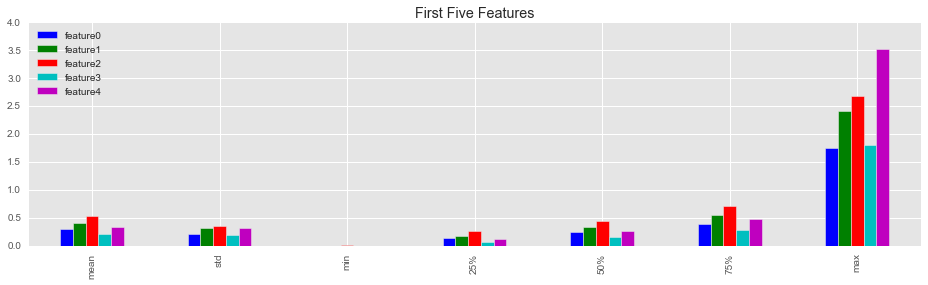

In [14]:
df[feature_cols[:5]].describe().ix[1:,].plot(kind='bar', figsize=(16, 4), title="First five features".title())

In [15]:
target_col = 'category'
X_all = df[feature_cols]  # feature values for all students
y_all = df[target_col]

In [16]:
X_all.shape

(3470, 2048)

In [48]:
y_all.shape

(3470,)

In [18]:
# Split up the train and test data
from sklearn.cross_validation import train_test_split

test_size = 0.3 # 30 percent
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=test_size, random_state=0, stratify=y_all)

# Split up the filepaths for comparison (useful for datamind benchmark)
X_train_filepath, X_test_filepath, y_train_filepath, y_test_filepath = train_test_split(
    df['filepath'], df.category.apply(cat_name), test_size=test_size, random_state=0, stratify=y_all)
train_data = pd.DataFrame({'filepath': X_train_filepath, 'category': y_train_filepath})
test_data = pd.DataFrame({'filepath': X_test_filepath, 'category': y_test_filepath})
train_data.to_csv('data/kfood_train.txt', index=False)
test_data.to_csv('data/kfood_test.txt', index=False)

# Test to see that the train_test_split splits the filepaths the same way as the feature data
np.array_equal(pd.merge(pd.DataFrame(X_train_filepath, columns=['filepath']), df, how='left', on='filepath')[feature_cols].values, X_train)

True

In [19]:
X_train.shape, X_test.shape

((2431, 2048), (1039, 2048))

In [20]:
y_train.shape, y_test.shape

((2431,), (1039,))

In [21]:
1039./2431

0.42739613327848625

In [25]:
from datsci.eda import pprint

In [22]:
split_counts_df = pd.concat([y_train.apply(cat_name).value_counts(), y_test.apply(cat_name).value_counts()], axis=1)
split_counts_df.columns = ['train', 'test']
split_counts_df['test_perc'] = split_counts_df.apply(lambda row: float(row.test) / row.sum(), axis=1)
split_counts_df

,train,test,test_perc
bibimbab,150,64,0.299065
bossam,121,52,0.300578
bulgogi,128,55,0.300546
dakbokeumtang,120,51,0.298246
dakgalbi,144,61,0.297561
ddukbokee,105,45,0.300000
galbijjim,153,66,0.301370
hotteok,147,63,0.300000
japchae,135,58,0.300518
jeon,94,40,0.298507


In [26]:
pprint(split_counts_df)

+---------------+-------+------+----------------+
|               | train | test |   test_perc    |
+---------------+-------+------+----------------+
|    bibimbab   |  150  |  64  | 0.299065420561 |
|     bossam    |  121  |  52  | 0.300578034682 |
|    bulgogi    |  128  |  55  | 0.300546448087 |
| dakbokeumtang |  120  |  51  | 0.298245614035 |
|    dakgalbi   |  144  |  61  | 0.29756097561  |
|   ddukbokee   |  105  |  45  |      0.3       |
|   galbijjim   |  153  |  66  | 0.301369863014 |
|    hotteok    |  147  |  63  |      0.3       |
|    japchae    |  135  |  58  | 0.300518134715 |
|      jeon     |   94  |  40  | 0.298507462687 |
| jeyookbokkeum |  116  |  49  | 0.29696969697  |
|     kimbab    |  152  |  65  | 0.299539170507 |
|     kimchi    |   89  |  38  | 0.299212598425 |
|    lagalbi    |  104  |  44  | 0.297297297297 |
|    nangmyun   |  145  |  62  | 0.299516908213 |
|     ramen     |   83  |  35  | 0.296610169492 |
|   samgyetang  |  111  |  47  | 0.29746835443  |


Classifiers to try in Sklearn:

- SVC
- KNeighborsClassifier
- RandomForestClassifier
- LogisticRegression
- GradientBoostingClassifier
- AdaBoostClassifier

In [14]:
import time
from sklearn.metrics import f1_score

def train_predict(clf, X_train, y_train, X_test, y_test, description):
    results = {'description': description}
    
    # Train
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    results['time_train'] = end - start

    # Predict train
    start = time.time()
    y_hat = clf.predict(X_train)
    end = time.time()
    results['f1_score_train'] = f1_score(y_train.values, y_hat, average='micro')
    results['time_predict_train'] = end - start

    # Predict test
    start = time.time()
    y_hat = clf.predict(X_test)
    end = time.time()
    results['f1_score_test'] = f1_score(y_test.values, y_hat, average='micro')
    results['time_predict_test'] = end - start

    return results


results = []

# SVC
from sklearn.svm import SVC

clf = SVC(C=1.0, kernel='linear', gamma='auto')
results.append(train_predict(clf, X_train, y_train, X_test, y_test, "SVC linear kernel, one-vs-one"))

clf = SVC(C=1.0, kernel='poly', degree=2, gamma='auto')
results.append(train_predict(clf, X_train, y_train, X_test, y_test, "SVC polynomial deg 2 kernel, one-vs-one"))

clf = SVC(C=1.0, kernel='poly', degree=3, gamma='auto')
results.append(train_predict(clf, X_train, y_train, X_test, y_test, "SVC polynomial deg 3 kernel, one-vs-one"))

clf = SVC(C=1.0, kernel='rbf', gamma='auto')
results.append(train_predict(clf, X_train, y_train, X_test, y_test, "SVC rbf kernel, one-vs-one"))

clf = sklearn.multiclass.OneVsRestClassifier(SVC(C=1.0, kernel='linear', gamma='auto'), n_jobs=2)
results.append(train_predict(clf, X_train, y_train, X_test, y_test, "SVC linear kernel, one-vs-rest"))

clf = sklearn.multiclass.OneVsRestClassifier(SVC(C=1.0, kernel='poly', degree=2, gamma='auto'), n_jobs=2)
results.append(train_predict(clf, X_train, y_train, X_test, y_test, "SVC linear poly deg 2 kernel, one-vs-rest"))

clf = sklearn.multiclass.OneVsRestClassifier(SVC(C=1.0, kernel='poly', degree=3, gamma='auto'), n_jobs=2)
results.append(train_predict(clf, X_train, y_train, X_test, y_test, "SVC linear poly deg 3 kernel, one-vs-rest"))

clf = sklearn.multiclass.OneVsRestClassifier(SVC(C=1.0, kernel='rbf', gamma='auto'), n_jobs=2)
results.append(train_predict(clf, X_train, y_train, X_test, y_test, "SVC rbf kernel, one-vs-rest"))

# K-Neighbors Classifier
from sklearn.neighbors import KNeighborsClassifier as KNC
clf = KNC(n_neighbors=3, weights='uniform')
results.append(train_predict(clf, X_train, y_train, X_test, y_test, "KNeighbors, 3 neighbors"))

# RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier as RFC
clf = RFC(n_estimators=10, max_depth=None, min_samples_split=2, n_jobs=2)
results.append(train_predict(clf, X_train, y_train, X_test, y_test, "RandomForest, 10 estimators"))

# LogisticRegression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l2', random_state=0, multi_class='ovr', n_jobs=4)
results.append(train_predict(clf, X_train, y_train, X_test, y_test, "LogisticRegression ovr"))

clf = LogisticRegression(penalty='l2', random_state=0, multi_class='multinomial', solver='lbfgs', n_jobs=1)
results.append(train_predict(clf, X_train, y_train, X_test, y_test, "LogisticRegression multinomial"))

# Tried boosting, but not such great results, so exclude from further analysis
# # GradientBoostingClassifier
# from sklearn.ensemble import GradientBoostingClassifier as GBC
# clf = GBC(loss='deviance', learning_rate=0.1, n_estimators=100, max_depth=None, min_samples_split=2)
# results.append(train_predict(clf, X_train, y_train, X_test, y_test, "GradientBoostingClassifier"))

# # AdaBoostClassifier
# from sklearn.ensemble import AdaBoostClassifier as ABC
# clf = ABC(SVC(C=1.0, kernel='linear', gamma='auto'), n_estimators=100, learning_rate=1.0, algorithm='SAMME')
#results.append(train_predict(clf, X_train, y_train, X_test, y_test, "AdaBoostClassifier w SVC linear kernel"))

In [17]:
# Re-run using just simple accuracy scores, in order to compare with retrain code in tensorflow/examples/image_retraining

import time
from sklearn.metrics import accuracy_score

def train_predict2(clf, X_train, y_train, X_test, y_test, description):
    results = {'description': description}
    
    # Train
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    results['time_train'] = end - start

    # Predict train
    start = time.time()
    y_hat = clf.predict(X_train)
    end = time.time()
    results['accuracy_train'] = accuracy_score(y_train.values, y_hat)
    results['time_predict_train'] = end - start

    # Predict test
    start = time.time()
    y_hat = clf.predict(X_test)
    end = time.time()
    results['accuracy_test'] = accuracy_score(y_test.values, y_hat)
    results['time_predict_test'] = end - start

    return results


results = []

from sklearn.svm import SVC

clf = SVC(C=1.0, kernel='linear', gamma='auto')
results.append(train_predict2(clf, X_train, y_train, X_test, y_test, "SVC linear kernel, one-vs-one"))

clf = SVC(C=1.0, kernel='poly', degree=2, gamma='auto')
results.append(train_predict2(clf, X_train, y_train, X_test, y_test, "SVC polynomial deg 2 kernel, one-vs-one"))

clf = SVC(C=1.0, kernel='poly', degree=3, gamma='auto')
results.append(train_predict2(clf, X_train, y_train, X_test, y_test, "SVC polynomial deg 3 kernel, one-vs-one"))

clf = SVC(C=1.0, kernel='rbf', gamma='auto')
results.append(train_predict2(clf, X_train, y_train, X_test, y_test, "SVC rbf kernel, one-vs-one"))

clf = sklearn.multiclass.OneVsRestClassifier(SVC(C=1.0, kernel='linear', gamma='auto'), n_jobs=2)
results.append(train_predict2(clf, X_train, y_train, X_test, y_test, "SVC linear kernel, one-vs-rest"))

clf = sklearn.multiclass.OneVsRestClassifier(SVC(C=1.0, kernel='poly', degree=2, gamma='auto'), n_jobs=2)
results.append(train_predict2(clf, X_train, y_train, X_test, y_test, "SVC linear poly deg 2 kernel, one-vs-rest"))

clf = sklearn.multiclass.OneVsRestClassifier(SVC(C=1.0, kernel='poly', degree=3, gamma='auto'), n_jobs=2)
results.append(train_predict2(clf, X_train, y_train, X_test, y_test, "SVC linear poly deg 3 kernel, one-vs-rest"))

clf = sklearn.multiclass.OneVsRestClassifier(SVC(C=1.0, kernel='rbf', gamma='auto'), n_jobs=2)
results.append(train_predict2(clf, X_train, y_train, X_test, y_test, "SVC rbf kernel, one-vs-rest"))

# K-Neighbors Classifier
from sklearn.neighbors import KNeighborsClassifier as KNC
clf = KNC(n_neighbors=3, weights='uniform')
results.append(train_predict2(clf, X_train, y_train, X_test, y_test, "KNeighbors, 3 neighbors"))

# RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier as RFC
clf = RFC(n_estimators=10, max_depth=None, min_samples_split=2, n_jobs=2)
results.append(train_predict2(clf, X_train, y_train, X_test, y_test, "RandomForest, 10 estimators"))

# LogisticRegression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l2', random_state=0, multi_class='ovr', n_jobs=4)
results.append(train_predict2(clf, X_train, y_train, X_test, y_test, "LogisticRegression ovr"))

clf = LogisticRegression(penalty='l2', random_state=0, multi_class='multinomial', solver='newton-cg', n_jobs=1)
results.append(train_predict2(clf, X_train, y_train, X_test, y_test, "LogisticRegression multinomial"))

In [18]:
print pd.DataFrame(results)

   accuracy_test  accuracy_train                     description  \
0       0.803657               1  LogisticRegression multinomial   

   time_predict_test  time_predict_train  time_train  
0           0.008209            0.010171   10.576213  


## Fine-tune SVC linear kernel and Logistic Regression ovr and multinomial models using logloss/cross entropy error

In [61]:
import time
from sklearn.grid_search import GridSearchCV as GSCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# SVC linear kernel
clf_svc = SVC(gamma='auto', probability=True)

best_score = None
best_params = None
for i in xrange(3):
    if i < 3 or i % 10 == 0:
	print "iteration {}".format(i)
	start = time.time()
    gs_clf = GSCV(
	clf_svc,
	{'kernel':['rbf'], 'C':[16, 16.5, 17, 17.5, 18]},
	scoring='log_loss',
	cv=5,
	n_jobs=4)
    gs_clf.fit(X_train, y_train)
    _score = accuracy_score(y_test, gs_clf.predict(X_test))
    if best_score is None or best_score < _score:
	best_score = _score
	best_params = {
	    'C': gs_clf.best_estimator_.C,
	    'kernel': gs_clf.best_estimator_.kernel}
    if i < 3:
	end = time.time()    
	print "Each iteration time(secs): {:.3f}".format(end - start)
	
print best_score, best_params

Each iteration time(secs): 266.620
0.796920115496 {'kernel': 'rbf', 'C': 17.5}
Each iteration time(secs): 262.910
iteration 2
Each iteration time(secs): 257.520
iteration 1
iteration 0


In [64]:
# Retrain SVC with all training data, and get accuracy on test data

clf_svc = SVC(kernel='rbf', C=17.5, gamma='auto', probability=True)
clf_svc.fit(X_train, y_train)
y_hat_svc = clf_svc.predict(X_test)
clf_svc_accuracy = accuracy_score(y_test.values, y_hat_svc)

In [77]:
clf_svc_results = pd.DataFrame({'y_hat': pd.Series(y_hat_svc).apply(cat_name).values, 'y_true': y_test.apply(cat_name).values})

In [78]:
clf_svc_results.head()

         y_hat       y_true
0      bulgogi      bulgogi
1      japchae      japchae
2    ddukbokee    ddukbokee
3  sullungtang  sullungtang
4    ddukbokee    ddukbokee

In [81]:
clf_svc_results.apply(lambda row: row.y_hat == row.y_true, axis=1).sum() / float(clf_svc_results.shape[0])

0.79692011549566888

In [65]:
clf_svc_accuracy

0.79692011549566888

In [82]:
clf_svc_results.to_csv('data/sklearn_svc_test_results.txt', index=False)

In [62]:
import time
from sklearn.grid_search import GridSearchCV as GSCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# Logistic Regression ovr

clf_lr = LogisticRegression(
    penalty='l2', random_state=0, multi_class='ovr', n_jobs=4)

best_score = None
best_params = None
for i in xrange(3):
    if i < 3 or i % 10 == 0:
	print "iteration {}".format(i)
	start = time.time()
    gs_clf = GSCV(
	clf_lr,
	{'tol': [1e-8, 1e-9, 1e-10], 'C': [.27, .3, .33]},
	scoring='log_loss',
	cv=5,
	n_jobs=1)
    gs_clf.fit(X_train, y_train)
    _score = accuracy_score(y_test, gs_clf.predict(X_test))
    if best_score is None or best_score < _score:
	best_score = _score
	best_params = {
	    'C': gs_clf.best_estimator_.C,
	    'tol': gs_clf.best_estimator_.tol}
    if i < 3:
	end = time.time()    
	print "Each iteration time(secs): {:.3f}".format(end - start)
	
print best_score, best_params


0.797882579403 {'C': 0.27, 'tol': 1e-08}

iteration 2
Each iteration time(secs): 881.821
iteration 1
Each iteration time(secs): 883.683iteration 0
Each iteration time(secs): 898.157

In [83]:
# Retrain LogisticRegression ovr with all training data and get accuracy on test data

clf_lr = LogisticRegression(C=0.27, tol=1e-08,
    penalty='l2', random_state=0, multi_class='ovr', n_jobs=8)
clf_lr.fit(X_train, y_train)
y_hat_lr = clf_lr.predict(X_test)
clf_lr_accuracy = accuracy_score(y_test.values, y_hat_lr)

In [95]:
clf_lr_accuracy

0.79788257940327234

In [85]:
clf_lr_results = pd.DataFrame({'y_hat': pd.Series(y_hat_lr).apply(cat_name).values, 'y_true': y_test.apply(cat_name).values})

In [89]:
clf_lr_results.to_csv('data/sklearn_lr_test_results.txt', index=False)

weird bug: 
running GridCV w LogisticRegression with n_jobs > 1 for LogisticRegression while n_jobs > 1 for GridCV causes cpu hang
Not sure if it's only for this version, or only for python 2.7.x
https://github.com/scikit-learn/scikit-learn/issues/3605
ovr: Keep LogisticRegression n_jobs > 1, but GridCV n_jobs = 1
multinomial: both n_jobs=1


In [63]:
import time
from sklearn.grid_search import GridSearchCV as GSCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# Logistic Regression multinomial

clf_lr2 = LogisticRegression(
    penalty='l2', random_state=0, multi_class='multinomial', solver='lbfgs', n_jobs=1)
    
best_score = None
best_params = None
for i in xrange(3):
    if i < 3 or i % 10 == 0:
	print "iteration {}".format(i)
	start = time.time()
    gs_clf = GSCV(
	clf_lr2,
	{'tol': [0.0001], 'C': [.17, .2, .23], 'max_iter': [270, 300, 350]},
	scoring='log_loss',
	cv=5,
	n_jobs=1)
    gs_clf.fit(X_train, y_train)
    _score = accuracy_score(y_test, gs_clf.predict(X_test))
    if best_score is None or best_score < _score:
	best_score = _score
	best_params = {
	    'C': gs_clf.best_estimator_.C,
	    'max_iter': gs_clf.best_estimator_.max_iter,
	    'tol': gs_clf.best_estimator_.tol}
    if i < 3:
	end = time.time()    
	print "Each iteration time(secs): {:.3f}".format(end - start)
	
print best_score, best_params


0.806544754572 {'C': 0.2, 'max_iter': 300, 'tol': 0.0001}

iteration 2
Each iteration time(secs): 158.727
iteration 1
Each iteration time(secs): 158.391iteration 0
Each iteration time(secs): 158.433

In [90]:
# Retrain LogisticRegression multinomial with all training data and get accuracy on test

clf_lr2 = LogisticRegression(C=0.2, max_iter=300, tol=0.0001,
    penalty='l2', random_state=0, multi_class='multinomial', solver='lbfgs', n_jobs=1)
clf_lr2.fit(X_train, y_train)
y_hat_lr2 = clf_lr2.predict(X_test)
clf_lr2_accuracy = accuracy_score(y_test.values, y_hat_lr2)

In [91]:
clf_lr2_accuracy

0.8065447545717036

In [92]:
clf_lr2_results = pd.DataFrame({'y_hat': pd.Series(y_hat_lr2).apply(cat_name).values, 'y_true': y_test.apply(cat_name).values})

In [93]:
clf_lr2_results.apply(lambda row: row.y_hat == row.y_true, axis=1).sum() / float(clf_lr2_results.shape[0])

0.8065447545717036

In [94]:
clf_lr2_results.to_csv('data/sklearn_lr2_test_results.txt', index=False)

Run with tensorflow retrain final layer from within `tensorflow/examples/image_retraining` -> `tensorflow_retrain`

```
time python retrain.py --image_dir kfood --output_graph ./kfood_graph.pb --output_labels ./kfood_output_labels.txt --how_many_training_steps 5000 --learning_rate 0.01 --testing_percentage 25 --validation_percentage 5 --train_batch_size 200 --noflip_left_right --random_crop 0 --random_scale 0 --random_brightness 0
```

In [ ]:
# Run again using final settings, and store log, to create plot of decreasing cross entropy and increasing accuracy values